In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import clear_output
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u

In [36]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()

In [3]:
icdata

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.37911273,3.31,0.48,203.024,16.760,218.374,106.712
1,54562.38662244,5.17,0.62,75.024,-13.371,349.100,76.646
2,54562.38789162,3.92,0.56,97.501,11.290,327.060,101.291
3,54562.39267689,5.57,1.13,305.857,-33.932,120.413,56.090
4,54562.40477593,5.80,1.11,143.516,-38.279,287.171,51.684
...,...,...,...,...,...,...,...
1134445,58307.96110988,5.14,0.20,221.246,-59.959,141.239,29.956
1134446,58307.96266638,2.94,1.23,191.547,4.415,171.627,94.312
1134447,58307.96355617,2.88,0.30,308.127,42.543,55.437,132.606
1134448,58307.96397167,2.98,0.21,332.199,44.720,31.489,134.811


In [4]:
#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr1.68.txt", 'r')
lines = f.readlines()
content=[]
column=lines.pop(0).replace('x', '').replace('#', '').split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
f.close()
mspdata = pd.DataFrame(content).drop(0, axis=1)#.dropna()#.drop_duplicates()#.drop(range(0,6)).dropna()

line = []
lines = []
mspdata.columns = column
column = []
content=[]
#mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
#mspdata = mspdata.reset_index()
#mspdata = mspdata.drop("index", axis=1)

In [5]:
mspdata

,NAME,RAJD,DECJD
0,J0002+6216,0.74238,62.26928
1,J0006+1834,1.52,18.5831
2,J0007+7303,1.7571,73.0521
3,J0011+08,2.9,8.17
4,B0011+47,3.57396,47.77594
...,...,...,...
3336,J2351+8533,357.764,85.55573
3337,J2352+65,358,65
3338,J2354-22,358.60833,-22.86472
3339,B2351+61,358.5199292,61.9296792


In [6]:
msra = np.array([float(i) for i in mspdata['RAJD'].values])
msdec = np.array([float(i) for i in mspdata['DECJD'].values])
icra = np.array([float(i) for i in icdata['RA[deg]']])
icdec = np.array([float(i) for i in icdata['Dec[deg]']])
icang = np.array([float(i) for i in icdata['AngErr[deg]']])
global p, lg
p = len(msra)
lg = len(icra) // p + 1
#cut = 20
#cone = 3
#psrno = 0

In [7]:
[min(msdec), max(msdec)]

[-83.298894, 86.720335]

In [8]:
icra[[0, 6, 8] ]

array([203.024, 147.017, 236.214])

In [14]:
def hvovec(lon1, lat1, lon2, lat2, rad=False):

    f'''
    Returns the haversine angle between two vectors given their latitude and longitude
    {rad} = True -> Angle is returned in radians
    {rad} = False (default) -> Angle is returned in Degrees

    #NOTE:
        This function assumes the input to be in degrees and of equal length
    '''

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    if rad == True:
        return np.arccos(a)
    else:
        return np.abs(np.rad2deg(np.arccos(a)))


def angdecfinder(psrno, declcut):

    f'''
    Returns the absolute difference between the declinations of pulsar  {psrno}
    and each of the neutrinos within the specified declcut
    '''

    #aang = hvovec(msra[psrno], msdec[psrno], icra, icdec)
    decdf = list(np.abs(np.subtract(icdec, msdec[psrno])))
    nuind = []
    for i in range(0, len(decdf)):
        if decdf[i] < declcut:
            nuind.append(i)
            #decdf.pop(i)
            #aang[i] = -1
    fdecdf = list(np.abs(np.subtract(icdec[nuind], msdec[psrno])))
    return [nuind, decdf]

def S_ij(psrno, nuind): 

    f'''
    Returns the signal PDF for the {psrno}th pulsar 
    and the all neutrinos within the specified declcut as given in {nuind}
    '''

    ang2 = hvovec(msra[psrno], msdec[psrno], icra[nuind], icdec[nuind], rad=True) ** 2
    sg = np.deg2rad(icang[nuind]) ** 2
    return np.exp(-1 * ang2 / (2 * sg)) / (2 * np.pi * sg)

def bgs(psrno, cone, twopi = False):

    f'''
    Returns the background PDF for a given pulsar {psrno} within 
    a cone of {cone} degrees for SINGLE STACKED ANALYSIS
    '''

    if twopi == True:
        s_ang = (np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone)))*(2 * np.pi)
        return 1/s_ang
    else:
        s_ang = (np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone)))
        return 1/s_ang

def Pr(x, Ns, S, B):

    '''
    Returns the probability of the selected set of neutrinos being associated with a given pulsar
    with {Ns} neutrinos, {S} signal and {B} background PDF and {x} assumed associated events
    '''

    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))


def TS(i, x, S, B, Ns):

    f'''Returns the Test Stastic value fot {i}^th grb
    at $n_s$ = {x} for its parameters S, B, Ns    '''
    
    return 2*np.sum(np.log(Pr(x,  Ns, S, B)/B))


def ns_for_TSmax(i, S, B, Ns):

    f'''
    Returns the value of $n_s$ for which
    the TS is maximum for {i}^th grb
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS(i,x, S, B, Ns)
    soln = minimize(nll, 3 ,bounds=((0,None),))
    ns = float(soln.x)
    return ns


In [15]:
def singpsr(psrno):
    cut = 5
    cone = 5
    nuind, decdf = angdecfinder(psrno, cut)
    S = S_ij(psrno, nuind)
    B = bgs(psrno, cone, True)
    Ns = len(nuind)
    maxns = ns_for_TSmax(psrno, S, B, Ns)
    return [maxns, np.sqrt(TS(psrno, maxns, S, B, Ns))]

tsmax = []
errpsr = []
pool = mul.Pool(8, maxtasksperchild=800)
op_async = pool.map_async(singpsr, range(p))
tsmax = op_async.get()
op_async = []
pool = []
'''
for i in range(p):
    #try:
    tsmax.append(singpsr2(i))
    #except TypeError:
     #   errpsr.append(i)'''
maxns = []
sqrtts = []
for i in tsmax:
    maxns.append(i[0])
    sqrtts.append(i[1])



sqrtt = np.sqrt(sqrtts)

np.argmax(sqrtt)

In [16]:
psrno = 0
cut = 5
cone = 5
nuind, decdf = angdecfinder(psrno, cut)
S = S_ij(psrno, nuind)
B = bgs(psrno, cone, True)
Ns = len(nuind)
maxns = ns_for_TSmax(psrno, S, B, Ns)

In [17]:
len(S)

38525

In [18]:
singpsr(971)

[0.0, 0.0]

38855


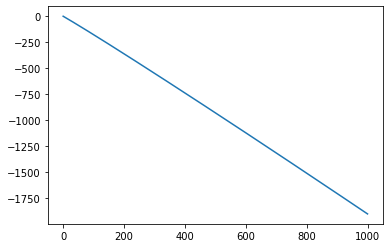

[0.0, 0.0]


In [19]:
def plotpsr(psrno):
    cut = 5
    cone = 5
    nuind, decdf = angdecfinder(psrno, cut)
    S = S_ij(psrno, nuind)
    B = bgs(psrno, cone)
    Ns = len(nuind)
    tns=[TS(psrno, i, S, B, Ns) for i in range(0, 1000)]
    print(Ns)
    plt.plot(range(0, 1000), tns)
    plt.show()
    print([ns_for_TSmax(psrno, S, B, Ns), TS(psrno, ns_for_TSmax(psrno, S, B, Ns), S, B, Ns)])
plotpsr(971)

In [20]:
def psrcustom(arr):
    cut = 5
    cone = 5
    for psrno in arr:
        nearcrd=[]
        for i in range(len(icdec)):
            if abs(icdec[i] - msdec[psrno]) <= cut:
                nearcrd.append([icra[i], icdec[i], icang[i]])
        print([psrno, msra[psrno], msdec[psrno]])
        np.savetxt(f"outputs/ndecnear{psrno}.txt", nearcrd)
        print("len(nearcrd) = ", len(nearcrd))

psrcustom([971])

[971, 228.43658, -59.77553]
len(nearcrd) =  38855


In [21]:
binnedsts, wsts = np.histogram(sqrtts, 10)

ne01 = 3
amp  = p/3.0#np.sum(binnedsts)/ne01
#binnedsts = binnedsts/amp
yerr = np.sqrt(binnedsts)
b2 = binnedsts[(binnedsts>10)]
yerr2 = yerr[(binnedsts>10)]
x=0.5*(wsts[1:]+ wsts[:-1])
x2 = x[(binnedsts>10)]
xerr=x[0]-wsts[0]

In [22]:
yerr

array([47.        , 18.24828759, 17.23368794, 14.62873884, 11.53256259,
        9.16515139,  6.92820323,  4.12310563,  1.73205081,  1.73205081])

In [23]:
wsts

array([0.        , 0.35025942, 0.70051885, 1.05077827, 1.4010377 ,
       1.75129712, 2.10155655, 2.45181597, 2.8020754 , 3.15233482,
       3.50259425])

In [24]:
#gaussian = lambda x, mean, var:  amp*norm.pdf(x, mean, var)
def gaussian(x,mean,sd):
#    mean=0.114
    A=p/3.0
    return A*np.exp(-(x - mean) ** 2.0 / sd ** 2.0)
loggaussian = lambda x, mean, var:  np.log(gaussian(x, mean, var))
gparam, gerr = curve_fit(gaussian, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True, maxfev = 10000, method='dogbox')
gx = np.linspace(0, wsts[-1], 100)

In [25]:
gparam

array([-0.75740907,  1.54199986])

kde = lambda x, binnedsts, var: max(b2)*gaussian_kde.pdf()
kparam, kerr = curve_fit(kde, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True, maxfev = 100000, method='dogbox')
kx = np.linspace(0, max(wsts), 100)

In [26]:
max(sqrtts)

3.5025942496699267

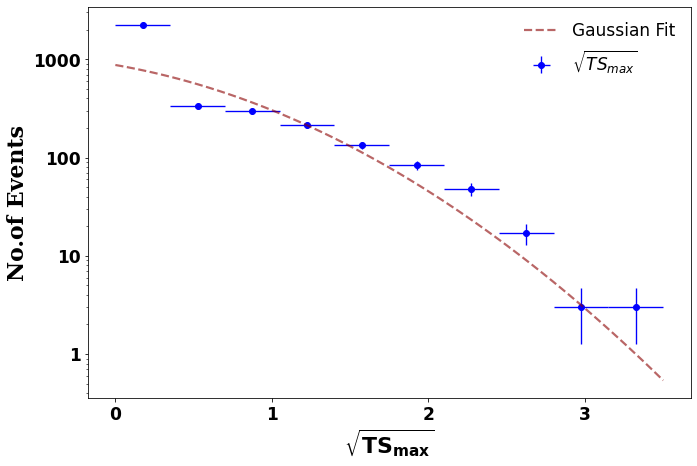

In [27]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=17, fontweight='bold')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize=17, fontweight='bold')

plt.errorbar(x, binnedsts, xerr=xerr,yerr=yerr,  aa = True, barsabove = True, fmt='ob',ecolor='blue', elinewidth=1.35, label='$\sqrt{TS_{max}}$')
plt.plot(gx,gaussian(gx, gparam[0], gparam[1]),'--', alpha=0.6, label=f'Gaussian Fit', color='darkred', lw=2.2)

plt.xlabel("$\mathbf{\sqrt{TS_{max}}}$", fontweight='bold', fontdict=font)
plt.ylabel("No.of Events", fontweight='bold', fontdict=font)
#plt.grid(True, which='major')
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.savefig("outputs/sqrt(TSmax)final.pdf")
plt.show()

In [28]:
binnedsts

array([2209,  333,  297,  214,  133,   84,   48,   17,    3,    3])

In [29]:
#arr = [i  for i in range(len(sqrtts)) if sqrtts[i] < 0.01]
#len(arr)
#psra = [msra[i] for i in arr]
#psdec = [msdec[i] for i in arr]
psra = msra
psdec = msdec
psra2 = np.deg2rad([(i + 180)%360 - 180 for i in psra])
nura = np.deg2rad([(i + 180)%360 - 180 for i in icra])
nudec = np.deg2rad(icdec)
#[psra[0], psra2[0]]
psra = np.deg2rad(psra)
psdec = np.deg2rad(psdec)
p3 =[]
for i in psra2:
    if i < 0 and i > np.deg2rad(-110):
        p3.append(i)

radec = scr(ra = msra * u.degree, dec = msdec * u.degree, frame = 'icrs')           #CONVERSION
nudec = scr(ra = icra * u.degree, dec = icdec * u.degree, frame = 'icrs')           #CONVERSION
radec = radec.galactic      #CONVERSION FROM RA,DEC TO GALACTIC COORDINATES
nudec = nudec.galactic      #CONVERSION FROM RA,DEC TO GALACTIC COORDINATES

gl = [(i + np.pi)%(2*np.pi) - np.pi for i in radec.l.radian]
gb = radec.b.radian

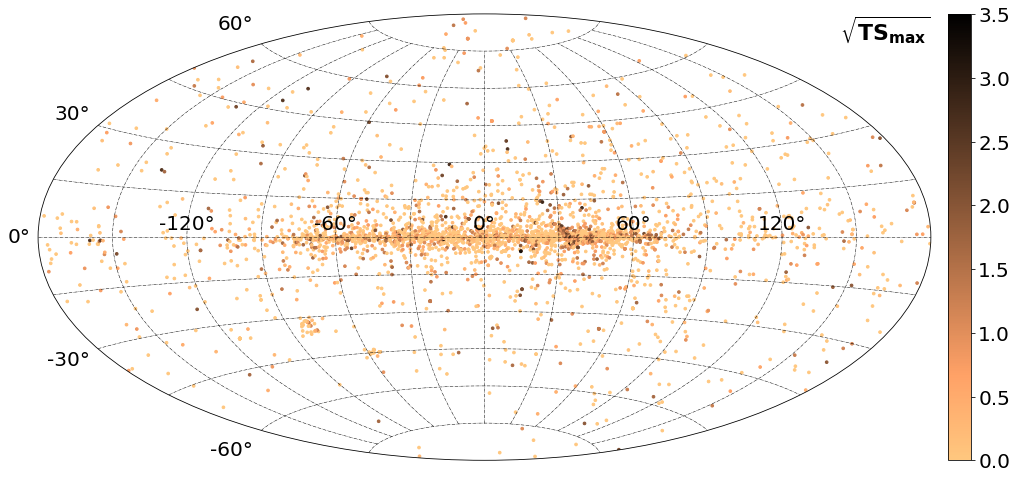

In [30]:
comap = 'copper_r'
fig = plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
ax2 = plt.subplot(projection='aitoff')
plott = ax2.scatter(gl, gb,marker='o', c=sqrtts, cmap=comap, s = 7, label='Pulsars')
#plt.title("GALACTIC COORDINATES", fontdict=font)
#ax2.scatter(msra, msdec,marker='o',color='b', s = 1.2)
#ax2.scatter(icra, icdec, marker='.',color='green', alpha=0.05, s = 0.1)
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2,2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='black', lw=0.5, ls='-.')
#ax2.axvspan(min(p3), max(p3), color='pink', alpha=0.5)
#ax2.set_title('PULSARS WITH TSmax ~0\nHAMMER projection \n', fontdict=font)

cax = fig.add_axes([ax2.get_position().x1+0.015,ax2.get_position().y0,0.02,ax2.get_position().height])
cbar = fig.colorbar(plott, cax=cax)
cbar.set_label('$\mathbf{\sqrt{TS_{max}}}$\n\n', loc='top', rotation=0,labelpad=-80, fontdict=font)
#plt.suptitle(filenamewithpath.replace('icecube_10year_ps/events/','').replace('_exp','') + ' GALACTIC')

plt.savefig('outputs/psr-tsmax_hmp-HP-Galactic.pdf')
plt.show()






#PLOT RA, DEC
comap = 'copper_r'
fig = plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
ax2 = plt.subplot(projection='hammer')
plott = ax2.scatter(psra2, psdec,marker='o', c=sqrtts, cmap=comap, s = 1.2, label='Pulsars')
plt.title("EQUATORIAL COORDINATES", fontdict=font)
#ax2.scatter(msra, msdec,marker='o',color='b', s = 1.2)
#ax2.scatter(icra, icdec, marker='.',color='green', alpha=0.05, s = 0.1)
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2,2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='black', lw=0.5, ls='-.')
#ax2.axvspan(min(p3), max(p3), color='pink', alpha=0.5)
#ax2.set_title('PULSARS WITH TSmax ~0\nHAMMER projection \n', fontdict=font)

cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height])
cbar = fig.colorbar(plott, cax=cax)
cbar.set_label('$\mathbf{\sqrt{TS_{max}}}$\n\n', loc='top', rotation=0,labelpad=-60, fontdict=font)
#plt.suptitle(filenamewithpath.replace('icecube_10year_ps/events/','').replace('_exp','') + ' GALACTIC')

plt.savefig('outputs/psr-tsmax_hmp-HP.pdf')
plt.show()
